In [1]:
import os
import sys
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
from env.amm import AMM
from env.oracle import OracleSimulator
from env.trader import Arbitrager

In [2]:
oracle = OracleSimulator(spread=1, sigma=1)
amm = AMM(fee_pool=True)
trader = Arbitrager(amm, oracle)

In [ ]:
mkt_bids = []
mkt_asks = []
amm_bids = []
amm_asks = []
swap_infos = []


for _ in range(20):
    mkt_ask, mkt_bid = oracle.get_price()
    amm_ask, amm_bid = amm.get_price()
    mkt_bids.append(mkt_bid)
    mkt_asks.append(mkt_ask)
    amm_bids.append(amm_bid)
    amm_asks.append(amm_ask)
    
    swap_info = trader.swap()
    swap_infos.append(swap_info)
    oracle.next()
print(f"final_pnl: {trader.pnl}")
    

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mkt_bids, label='mkt_bid')
plt.plot(mkt_asks, label='mkt_ask')
plt.step(range(len(amm_bids)), amm_bids, label='amm_bid', linestyle='--', where='pre')
plt.step(range(len(amm_asks)), amm_asks, label='amm_ask', linestyle='--', where='pre')
plt.legend()
plt.show()


In [ ]:
from pprint import pprint
for idx, swap_info in enumerate(swap_infos):
    print(f'Round {idx}')
    pprint(swap_info)

In [6]:
import pandas as pd

start_price=500
mu=0.06
dt=1/(252*6.5*60*60)
steps=int(60*60*6.5)
spread=0.005
fee_rate = 0.003
sigma = 0.4
iterations = 1000
    
amm = AMM(fee=fee_rate, fee_pool=False)
market = OracleSimulator(sigma=sigma,
                         mu=mu,
                         start_price=start_price,
                         steps=steps,
                         spread=spread,
                         dt=dt)

trader = Arbitrager(amm, market)
initial_pool_value = amm.lr * market.get_mid_price('r') + amm.ls * market.get_mid_price('s')
# Loop over market steps
for iter in range(iterations):
    record = []
    for _ in range(int(market.steps)):
        # Get trader observations
        swap_info = trader.swap()
        record.append(swap_info)
        market.next()
    trader.reset()
    if record[-1]['impermanent_loss'] > 0:
        # make recorder as dataframe
        record = pd.DataFrame(record)
        record.to_csv('positive_loss_record.csv')
        break
    
    


## check the xr sign

In [ ]:
# select rows where xs and xr are not zero
transaction_record = record[(record['xs'] != 0) & (record['xr'] != 0)]
# select rows where prev_amm_ask < mkt_bid
transaction_record_amm_mkt = transaction_record[transaction_record['prev_amm_ask'] < transaction_record['mkt_bid']]
# test whether in this case the xr should be negative
print(f"xr negative when amm ask is lower than mkt bid: {(transaction_record_amm_mkt['xr']<0).sum()}")
print(f"total transaction: {transaction_record_amm_mkt.shape[0]}")

# select rows where prev_amm_bid > mkt_ask
transaction_record_mkt_amm = transaction_record[transaction_record['prev_amm_bid'] > transaction_record['mkt_ask']]
# test whether in this case the xr should be positive
print(f"xr positive when amm ask is higher than mkt bid: {(transaction_record_mkt_amm['xr']>0).sum()}")
print(f"total transaction: {transaction_record_mkt_amm.shape[0]}")

## check the alignment of two prices

In [ ]:
# select rows where xs and xr are not zero
transaction_record = record[(record['xs'] != 0) & (record['xr'] != 0)]
transaction_record_amm_mkt = transaction_record[transaction_record['prev_amm_ask'] < transaction_record['mkt_bid']]
# check whether the amm ask equals to mkt bid
print(f"amm ask equals to mkt bid: {((transaction_record_amm_mkt['prev_amm_ask'] - transaction_record_amm_mkt['mkt_bid'])<1e16).sum()}")
print(f"total transaction: {transaction_record_amm_mkt.shape[0]}")

transaction_record_mkt_amm = transaction_record[transaction_record['prev_amm_bid'] > transaction_record['mkt_ask']]
# check whether the amm bid equals to mkt ask
print(f"amm bid equals to mkt ask: {((transaction_record_mkt_amm['prev_amm_bid'] - transaction_record_mkt_amm['mkt_ask'])<1e16).sum()}")
print(f"total transaction: {transaction_record_mkt_amm.shape[0]}")


# check the fee, impermanent loss, and net profit

In [ ]:
import numpy as np

# Select rows where xs and xr are not zero
record['prev_fee'] = record['total_fee_dollar_value'].shift(1)
transaction_record = record[(record['xs'] == 0) & (record['xr'] == 0)][1:]

# Check if the fee is not changing
fee_not_changing = np.isclose(transaction_record['total_fee_dollar_value'], transaction_record['prev_fee'], atol=1e-6)
print(f"Fee not changing: {fee_not_changing.sum()}")
print(f"Total transactions checked: {transaction_record.shape[0]}")

# Check if the current pool value is correctly calculated
current_pool_value_correct = np.isclose(record['mid_r'] * record['lr'] + record['mid_s'] * record['ls'], record['current_pool_value'], atol=1e-6)
print(f"Current pool value correctly calculated: {current_pool_value_correct.sum()}")

# Check if the initial pool value is correctly calculated
initial_pool_value_correct = np.isclose(record['mid_r'] * 1000000 + record['mid_s'] * 1000000, record['initial_pool_value'], atol=1e-6)
print(f"Initial pool value correctly calculated: {initial_pool_value_correct.sum()}")

# Check if the impermanent loss is correctly calculated
impermanent_loss_correct = np.isclose(record['impermanent_loss'], record['current_pool_value'] - record['initial_pool_value'], atol=1e-6)
print(f"Impermanent loss correctly calculated: {impermanent_loss_correct.sum()}")

# check if the net profit is the sum of the total_fee_dollar_value and the impermanent_loss
net_profit_correct = np.isclose(record['net_profit'], record['total_fee_dollar_value'] + record['impermanent_loss'], atol=1e-6)
print(f"Net profit correctly calculated: {net_profit_correct.sum()}")


# Summary count of total transactions
print(f"Total transactions: {record.shape[0]}")


In [ ]:
print(f"current_pool_value: {997008.2936108732 * 501.4798212189421 + 1003000.683553285 * 499.9936850298152}")

In [ ]:
print(f"initial_pool_value: {1000000 * 501.4798212189421 + 1000000 * 499.9936850298152}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

record = pd.read_csv('/home/shiftpub/Dynamic_AMM/env/positive_loss_record.csv')

# Plot the impermanent loss
plt.figure(figsize=(12, 6))
plt.plot(record['impermanent_loss'], label='Impermanent Loss', color='blue')

# Find positive impermanent loss points
positive_impermanent_loss = record[record['impermanent_loss'] > 0]

# Highlight positive impermanent loss points with larger, distinctive markers
plt.scatter(positive_impermanent_loss.index, positive_impermanent_loss['impermanent_loss'], 
            color='red', s=50, marker='D', label='Positive Impermanent Loss')

# Annotate the first positive impermanent loss point
first_positive_index = positive_impermanent_loss.index[0]
first_positive_value = positive_impermanent_loss['impermanent_loss'].iloc[0]

plt.annotate(f'{first_positive_value:.2f}', 
             xy=(first_positive_index, first_positive_value), 
             xytext=(first_positive_index, first_positive_value - 50000),  # Adjust offset as needed
             fontsize=10, color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Impermanent Loss')
plt.title('Impermanent Loss with Highlighted Positive Values')
plt.legend()

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create the figure and primary y-axis for impermanent loss
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot impermanent loss on the primary y-axis
ax1.plot(record['impermanent_loss'], label='Impermanent Loss', color='blue')
positive_impermanent_loss = record[record['impermanent_loss'] > 0]
ax1.scatter(positive_impermanent_loss.index, positive_impermanent_loss['impermanent_loss'], 
            color='red', s=50, marker='D', label='Positive Impermanent Loss')

# Annotate the first positive impermanent loss point
first_positive_index = positive_impermanent_loss.index[0]
first_positive_value = positive_impermanent_loss['impermanent_loss'].iloc[0]
ax1.annotate(f'{first_positive_value:.2f}', 
             xy=(first_positive_index, first_positive_value), 
             xytext=(first_positive_index+1000, first_positive_value),  # Adjust as needed
             fontsize=10, color='red')

# Labels for primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Impermanent Loss')
ax1.set_title('Impermanent Loss with Market and AMM Bid/Ask Prices')
# ax1.legend(loc='lower left')

# Create a secondary y-axis for bid/ask prices
ax2 = ax1.twinx()
ax2.plot(record['mkt_bid'], label='mkt_bid', color='blue', linestyle='dotted')
ax2.plot(record['mkt_ask'], label='mkt_ask', color='orange', linestyle='dotted')
ax2.step(range(len(record['amm_bid'])), record['amm_bid'], label='amm_bid', linestyle='--', color='green', where='pre')
ax2.step(range(len(record['amm_ask'])), record['amm_ask'], label='amm_ask', linestyle='--', color='red', where='pre')

# Labels and legend for secondary y-axis
ax2.set_ylabel('Bid/Ask Prices')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

record = record[:10]

# Create the figure and primary y-axis for impermanent loss
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot impermanent loss on the primary y-axis
ax1.plot(record['impermanent_loss'], label='Impermanent Loss', color='blue')
positive_impermanent_loss = record[record['impermanent_loss'] > 0]
ax1.scatter(positive_impermanent_loss.index, positive_impermanent_loss['impermanent_loss'], 
            color='red', s=50, marker='D', label='Positive Impermanent Loss')

# Annotate the first positive impermanent loss point
# first_positive_index = positive_impermanent_loss.index[0]
# first_positive_value = positive_impermanent_loss['impermanent_loss'].iloc[0]
# ax1.annotate(f'{first_positive_value:.2f}', 
#              xy=(first_positive_index, first_positive_value), 
#              xytext=(first_positive_index+1000, first_positive_value),  # Adjust as needed
#              fontsize=10, color='red')

# Labels for primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Impermanent Loss')
ax1.set_title('Impermanent Loss with Market and AMM Bid/Ask Prices')
# ax1.legend(loc='lower left')

# Create a secondary y-axis for bid/ask prices
ax2 = ax1.twinx()
ax2.plot(record['mkt_bid'], label='mkt_bid', color='blue', linestyle='dotted')
ax2.plot(record['mkt_ask'], label='mkt_ask', color='orange', linestyle='dotted')
ax2.step(range(len(record['amm_bid'])), record['amm_bid'], label='amm_bid', linestyle='--', color='green', where='pre')
ax2.step(range(len(record['amm_ask'])), record['amm_ask'], label='amm_ask', linestyle='--', color='red', where='pre')

# Labels and legend for secondary y-axis
ax2.set_ylabel('Bid/Ask Prices')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.show()


In [ ]:
print(record.iloc[0])

In [ ]:
print(999563.6538614327 * 1000436.5366196356)

In [ ]:
501.90687821430606

In [ ]:
501.9029510921559

In [ ]:
initial = 1000000*501.90687821430606 + 1000000*501.9029510921559
end = 999563.6538614327 * 501.90687821430606 + 1000436.5366196356 * 501.9029510921559
print(end - initial)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("/home/shiftpub/Dynamic_AMM/env/positive_loss_record.csv")

# Identify the row index where the impermanent loss is positive
positive_loss_idx = df[df['impermanent_loss'] > 0].index[0]

# Select specific rows by index
tmp = df.iloc[[0, positive_loss_idx - 1, positive_loss_idx]].copy()

# Set the 'time_stamp' values using .loc to avoid the warning
tmp.loc[:, 'time_stamp'] = ['t0', 'T-1', 'T']

# Print impermanent loss to verify
print(tmp['impermanent_loss'])


0        0.000000
196   -109.694946
197     37.715159
Name: impermanent_loss, dtype: float64


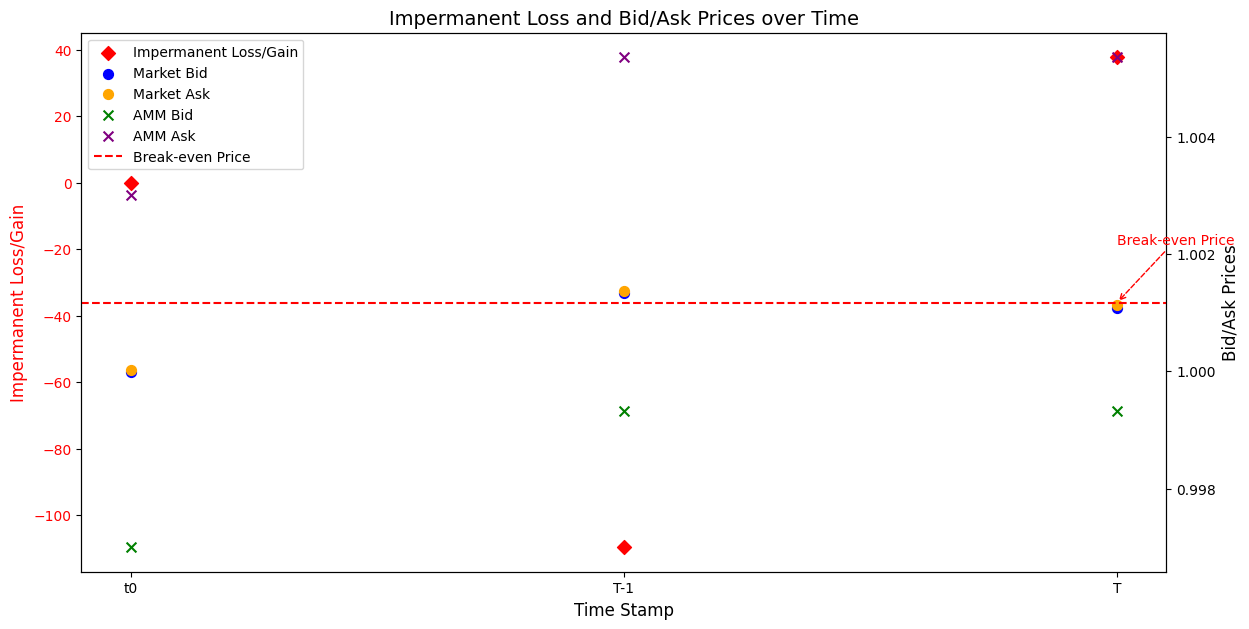

In [13]:
import matplotlib.pyplot as plt

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot impermanent loss on the primary y-axis
ax1.scatter(tmp['time_stamp'], tmp['impermanent_loss'], color='red', s=50, marker='D', label='Impermanent Loss/Gain')
ax1.set_ylabel('Impermanent Loss/Gain', color='red', fontsize=12)
ax1.set_xlabel('Time Stamp', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')

# Create a secondary y-axis for bid/ask prices
ax2 = ax1.twinx()
ax2.scatter(tmp['time_stamp'], tmp['mkt_bid'], color='blue', s=50, marker='o', label='Market Bid')
ax2.scatter(tmp['time_stamp'], tmp['mkt_ask'], color='orange', s=50, marker='o', label='Market Ask')
ax2.scatter(tmp['time_stamp'], tmp['amm_bid'], color='green', s=50, marker='x', label='AMM Bid')
ax2.scatter(tmp['time_stamp'], tmp['amm_ask'], color='purple', s=50, marker='x', label='AMM Ask')

# Add a horizontal line for the break-even price
break_even_price = 1.00116765393014
ax2.axhline(y=break_even_price, color='red', linestyle='--', label='Break-even Price')

# Add an annotation for the break-even price with an offset to avoid overlap
ax2.annotate(
    'Break-even Price',
    xy=(tmp['time_stamp'].iloc[-1], break_even_price),  # Position at last timestamp on the line
    xytext=(tmp['time_stamp'].iloc[-1], break_even_price*1.001),  # Offset for readability
    arrowprops=dict(arrowstyle="->", color='red', linestyle="--"),
    fontsize=10,
    color='red'
)

# Set y-axis label for bid/ask prices
ax2.set_ylabel('Bid/Ask Prices', fontsize=12)
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

# Add a title and grid for clarity
plt.title('Impermanent Loss and Bid/Ask Prices over Time', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


In [15]:
print(f"lr at t0: {tmp['lr'].iloc[0]} | lr at T-1: {tmp['lr'].iloc[1]} | lr at T: {tmp['lr'].iloc[2]}")
print(f"ls at t0: {tmp['ls'].iloc[0]} | ls at T-1: {tmp['ls'].iloc[1]} | ls at T: {tmp['ls'].iloc[2]}")
print(f"mid_r at t0: {tmp['mid_r'].iloc[0]} | mid_r at T-1: {tmp['mid_r'].iloc[1]} | mid_r at T: {tmp['mid_r'].iloc[2]}")
print(f"mid_s at t0: {tmp['mid_s'].iloc[0]} | mid_s at T-1: {tmp['mid_s'].iloc[1]} | mid_s at T: {tmp['mid_s'].iloc[2]}")
print(f"impermanent loss at t0: {tmp['impermanent_loss'].iloc[0]} | impermanent loss at T-1: {tmp['impermanent_loss'].iloc[1]} | impermanent loss at T: {tmp['impermanent_loss'].iloc[2]}")


lr at t0: 1000000.0 | lr at T-1: 998833.709957891 | lr at T: 998833.709957891
ls at t0: 1000000.0 | ls at T-1: 1001167.6518628492 | ls at T: 1001167.6518628492
mid_r at t0: 500.0 | mid_r at T-1: 500.7456307391662 | mid_r at T: 500.7213872377537
mid_s at t0: 500.0 | mid_s at T-1: 500.0676711889462 | mid_s at T: 500.16970087311006
impermanent loss at t0: 0.0 | impermanent loss at T-1: -109.6949461698532 | impermanent loss at T: 37.71515893936157


In [ ]:
print(f"current ratio: {tmp['mid_r'].iloc[2] / tmp['mid_s'].iloc[2]}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Explicitly set the values in 'time_stamp' column using .loc
tmp.loc[:, 'time_stamp'] = ['t0', 'T-1', 'T']
oracle_price_ratios2 = []
impermanent_losses2 = []
external_prices = []

# Store initial mid prices to reset after each iteration
initial_mid_r = tmp['mid_r'].iloc[-1]
initial_mid_s = tmp['mid_s'].iloc[-1]

# Constants to avoid recalculating in the loop
amm_ask = tmp['amm_ask'].iloc[2]
amm_bid = tmp['amm_bid'].iloc[2]

# Iterate over a range of price adjustments
for p in np.linspace(-1, 2, 1000):
    for q in np.linspace(-1, 2, 1000):
        # Adjust the mid price at the final timestamp by adding p and q
        adjusted_mid_r = initial_mid_r + p
        adjusted_mid_s = initial_mid_s + q
        
        # Calculate the price ratio
        price_ratio = adjusted_mid_r / adjusted_mid_s
        initial_value = 1000000 * adjusted_mid_r + 1000000 * adjusted_mid_s

        # Check if price ratio is within the AMM bid/ask range at timestamp 'T'
        if (price_ratio > amm_ask) or (price_ratio < amm_bid):
            continue  # Skip the iteration if the price ratio is outside the AMM bid/ask range
        
        # Calculate impermanent loss based on the adjusted values
        il = (adjusted_mid_r * tmp['lr'].iloc[2] + adjusted_mid_s * tmp['ls'].iloc[2]) - initial_value
        
        # Append the oracle price ratio and calculated impermanent loss
        oracle_price_ratios2.append(price_ratio)
        impermanent_losses2.append(il)
        external_prices.append((adjusted_mid_r, adjusted_mid_s))

print(f"ratio range: {min(oracle_price_ratios2)} - {max(oracle_price_ratios2)}")
print(f"amm ask bid range: {amm_bid} - {amm_ask}")



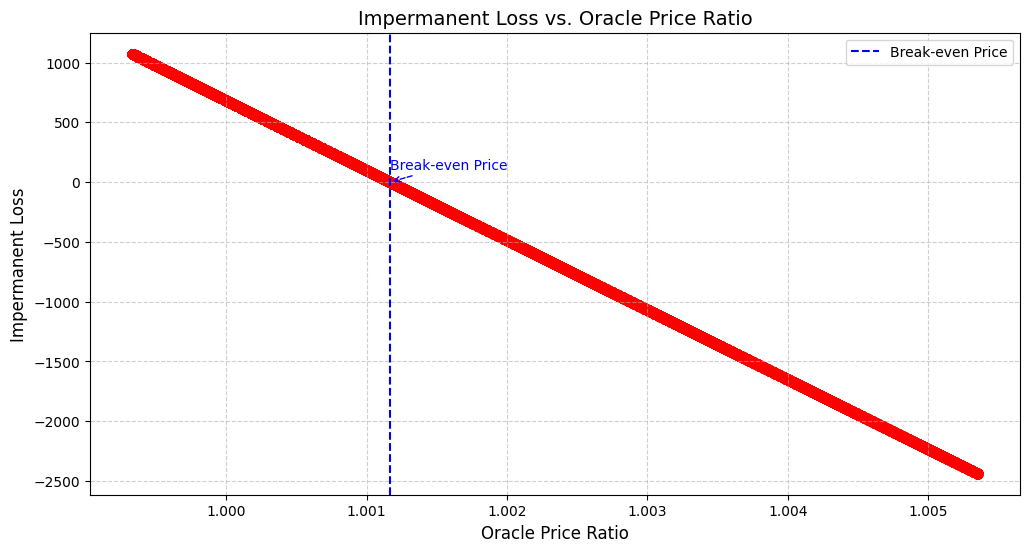

In [20]:
# Plotting the oracle price ratio against impermanent loss
plt.figure(figsize=(12, 6))
plt.scatter(oracle_price_ratios2, impermanent_losses2, color='red', alpha=0.7)

# Add the vertical line for the break-even price
break_even_price = 1.00116765393014
plt.axvline(x=break_even_price, color='blue', linestyle='--', label='Break-even Price')

# Add an annotation for the break-even price with an offset to avoid overlap
plt.annotate(
    'Break-even Price', 
    xy=(break_even_price, 0), 
    xytext=(break_even_price, max(impermanent_losses2) * 0.1),
    arrowprops=dict(arrowstyle="->", color='blue', linestyle="--"),
    fontsize=10,
    color='blue'
)

# Set labels and title
plt.xlabel('Oracle Price Ratio', fontsize=12)
plt.ylabel('Impermanent Loss', fontsize=12)
plt.title('Impermanent Loss vs. Oracle Price Ratio', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend()
plt.show()


In [ ]:
# find the idx where impermanent loss is close to 0
idx = np.argmin(np.abs(np.array(impermanent_losses2)))
print(f"idx: {idx}")
print(f"oracle price ratio: {oracle_price_ratios2[idx]}")
print(f"external price: {external_prices[idx]}")

In [ ]:
# look at the index of the highest impermanent loss
idx = np.argmax(impermanent_losses2)
print(f"Index of the highest impermanent loss: {idx}")
# print the external prices that resulted in the highest impermanent loss
print(f"External prices that resulted in the highest impermanent loss: {external_prices[idx]}")

In [ ]:
500.7456307391662 * 998833.709957891 + 500.0676711889462 * 1001167.6518628492

In [ ]:
1000000 * 500.7456307391662 + 1000000 * 500.0676711889462

In [ ]:
998833.709957891 * 500.7213872377537 + 1001167.6518628492 * 500.16970087311006

In [ ]:
1000000 * 500.7213872377537 + 1000000 * 500.16970087311006

In [ ]:
998833.709957891 * 500 + 1001167.6518628492 * 500